In [10]:
import numpy as np
import pandas as pd
import os
import torch 
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch.utils.data
import time
import itertools
import glob 
from PIL import Image
import csv 
import cv2
import re
import torchvision
import random
from xml.etree import ElementTree
from torchvision.ops.boxes import box_iou
import matplotlib.pyplot as plt
import sys
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [11]:
#Packages commonly needed to install pycocotools, tqdm, and requests.
import torch.backends.cudnn as cudnn


%cd EfficientDet.Pytorch-Updated/
import math
from models.efficientnet import EfficientNet
from models.bifpn import BIFPN
from models.retinahead import RetinaHead
from models.module import RegressionModel, ClassificationModel, Anchors, ClipBoxes, BBoxTransform
from torchvision.ops import nms
from models.losses import FocalLoss
from models.efficientdet import EfficientDet
from models.losses import FocalLoss
from datasets import VOCDetection, CocoDataset, get_augumentation, detection_collate, Resizer, Normalizer, Augmenter, collater
from utils import EFFICIENTDET, get_state_dict
from eval import evaluate, evaluate_coco
%cd ..

/home/sarthak/DataSets/ILSVRC2015/EfficientDet.Pytorch-Updated
/home/sarthak/DataSets/ILSVRC2015


In [12]:
torch.cuda.is_available(), torch.cuda.device_count()

(True, 2)

In [13]:
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
%cd Ranger-Deep-Learning-Optimizer
!pip install -e .
from ranger import Ranger  
%cd ..
#https://paperswithcode.com/paper/sharpness-aware-minimization-for-efficiently-1
!git clone https://github.com/davda54/sam.git
%cd sam
import sam
print("Imported SAM Successfully from github .py file")
%cd ..

fatal: destination path 'Ranger-Deep-Learning-Optimizer' already exists and is not an empty directory.
/home/sarthak/DataSets/ILSVRC2015/Ranger-Deep-Learning-Optimizer
Obtaining file:///home/sarthak/DataSets/ILSVRC2015/Ranger-Deep-Learning-Optimizer
  Attempting uninstall: ranger
    Found existing installation: ranger 0.1.dev0
    Uninstalling ranger-0.1.dev0:
      Successfully uninstalled ranger-0.1.dev0
  Running setup.py develop for ranger
/home/sarthak/DataSets/ILSVRC2015
fatal: destination path 'sam' already exists and is not an empty directory.
/home/sarthak/DataSets/ILSVRC2015/sam
Imported SAM Successfully from github .py file
/home/sarthak/DataSets/ILSVRC2015


## To DO 

### Configure fast rcnn model for training overnight





### Fix the metric creating of Effecient Det Model. 

* Push learning rate higher (current lr) * 10

Way to make Effecient Det work: 
* Turn the model to train mode
* Put some annotations and an image into the model and run it, which will get the output that will enter run metrics batch
* Then try running model on that input with bigger batch sizes. 
* Figure out how to get the data for one image in calculate metrics 
* Generalize to see how a batch of predictions can be run to the metrics
* Make sure mAP and missed images are the only things coming in and out.
* Put code into function and run it.







# Goal:

Get acceptable resukts with a rcnn torchvision model
Get acceptable results with effecient det

### Some Errors I get

Value Error in Det dataset
Model sometimes gets error while running on data.

### Advice

Try to start with simplest (Adam basics) and keep on adding stuff to improve mAP
 How much data 57 k in Det dataset
 Full validation has 170,00 but use 
 
 * (2,000 images in valid loader).
* 10 - 15 images per folder.

Great Proportions is that around 35 - 40% should be the Det Dataset and 60 - 65 % should be the sampled VID Dataset. 

### Get better results

* Reduce dataset to 5000 train images and 500 valid images

In [5]:
import sys
!{sys.executable} -m pip install --upgrade torchvision

In [3]:
!{sys.executable} -m pip install --upgrade albumentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [14]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed = 42)

In [15]:
def get_class_info(get_keys = False, smaller_mb_net = False):
    obj_dict = {
    "n02691156": "airplane", 
    "n02419796": "antelope", 
    "n02131653": "bear", 
    "n02834778": "bicycle", 
    "n01503061": "bird", 
    "n02924116": "bus", 
    "n02958343": "car", 
    "n02402425": "cattle", 
    "n02084071": "dog", 
    "n02121808": "domestic_cat", 
    "n02503517": "elephant", 
    "n02118333": "fox",
    "n02510455": "giant_panda", 
    "n02342885": "hamster", 
    "n02374451": "horse", 
    "n02129165": "lion", 
    "n01674464": "lizard", 
    "n02484322": "monkey", 
    "n03790512": "motorcycle", 
    "n02324045": "rabbit",
    "n02509815": "red_panda", 
    "n02411705": "sheep", 
    "n01726692": "snake", 
    "n02355227": "squirrel", 
    "n02129604": "tiger", 
    "n04468005": "train", 
    "n01662784": "turtle", 
    "n04530566": "watercraft", 
    "n02062744": "whale",
    "n02391049": "zebra"
    }
    
    if get_keys:
        return list(obj_dict.keys())
    
    return obj_dict

In [16]:
class VideoFrameDataset():
    
    def __init__(self, mode, vid_data_root_dir, vid_annotations_root_dir, transforms, seg_len = None, 
               make_valid_smaller_percent = None, effdet_data = None, rcnn_big = None, det_text_file_paths = None, 
               data_size = None):
                 
        
    # If valid smaller is true cut the length of valid list to certain length with if statement. 
        if (mode == "train"):
            if (seg_len):
                ORIG_SEG_LEN = seg_len
                #Subset images from every scene there are 3862 data folders.
                print("There are 1122397 train images in total")
                globbed_image_file_paths = sorted(glob.glob("{}/*/*".format(vid_data_root_dir)))
                globbed_annotations_file_paths = sorted(glob.glob("{}/*/*".format(vid_annotations_root_dir)))
                
                self.image_file_paths, self.annotations_file_paths = list(), list()
                
                for folder in list(zip(globbed_image_file_paths, globbed_annotations_file_paths)):
                    scene_images = sorted(glob.glob("{}/*.JPEG".format(folder[0])))
                    scene_annotations = sorted(glob.glob("{}/*.xml".format(folder[1])))
                    
                    image_annot = list(zip(scene_images, scene_annotations))

                    if seg_len % 5 != 0:
                        raise ValueError("Not allowed value for seg_len must be divisible by 5")
                    if seg_len >= len(image_annot):
                        seg_len = 5
                    
                    if len(image_annot) % seg_len != 0:
                        image_annot = image_annot[:-(len(image_annot) % seg_len)]
                    
                    red_img_annot, start_index = list(), 0 
                    
                    for window in range(int(len(image_annot) / seg_len)):
                        end_index = start_index + seg_len
                        red_img_annot.append(random.sample(image_annot[start_index : end_index], 1)[0])
                        start_index = end_index
                    
                   
                    scene_images, scene_annotations = zip(*red_img_annot) 
                    
                    self.annotations_file_paths.extend(scene_annotations)
                    self.image_file_paths.extend(scene_images)
                    
                    seg_len = ORIG_SEG_LEN
                    
            else:
                self.image_file_paths = sorted(glob.glob("{}/*/*/*.JPEG".format(vid_data_root_dir))) 
                self.annotations_file_paths = sorted(glob.glob("{}/*/*/*.xml".format(vid_annotations_root_dir)))
            
        elif (mode == "validation"):
            if make_valid_smaller_percent:
                #Subset a percent of the valid data
                valid_image_list = sorted(glob.glob("{}/*/*.JPEG".format(vid_data_root_dir)))
                valid_annotations_list = sorted(glob.glob("{}/*/*.xml".format(vid_annotations_root_dir)))

                subset = int(len(valid_image_list) * make_valid_smaller_percent)

                #Shuffle both lists at once with same order
                mapIndexPosition = list(zip(valid_image_list, valid_annotations_list))
                random.shuffle(mapIndexPosition)
                valid_image_list, valid_annotations_list = zip(*mapIndexPosition)
                valid_image_list, valid_annotations_list = list(valid_image_list), list(valid_annotations_list)

                self.image_file_paths = valid_image_list[:subset]
                self.annotations_file_paths = valid_annotations_list[:subset]
            else:
                self.image_file_paths = sorted(glob.glob("{}/*/*.JPEG".format(vid_data_root_dir))) 
                self.annotations_file_paths = sorted(glob.glob("{}/*/*.xml".format(vid_annotations_root_dir)))
        else:
            raise ValueError("Choose mode between train or validation only")

        self.labels_key = get_class_info(get_keys = True)

        self.data_size = data_size
        self.transforms = transforms
        self.effdet_data = effdet_data
        self.rcnn_big = rcnn_big
        
        if det_text_file_paths:
            home_file_path_data = "/data1/group/mlgroup/train_data/ILSVRC2015/Data/DET/"
            home_file_path_annot = "/data1/group/mlgroup/train_data/ILSVRC2015/Annotations/DET/"
            
            assert len(self.image_file_paths) == len(self.annotations_file_paths)
            print("\n")
            print("BEFORE DET: Amount of image files in Dataset {}".format(len(self.image_file_paths)))
            print("BEFORE DET: Amount of annotation files in Dataset {} \n".format(len(self.annotations_file_paths)))
            det_txt = open(det_text_file_paths, "r").readlines()
            np.random.shuffle(det_txt)
            
            #I am gonna sample about 10k images or around 20% of Det Dataset
            det_txt = det_txt[:int(len(det_txt) * 0.6)]
            print("Amount of images in Det Set (Approx.) {}".format(len(det_txt)))
            
            for line in det_txt:
                self.image_file_paths.append((home_file_path_data + line.split(" ")[0] + ".JPEG"))
                self.annotations_file_paths.append((home_file_path_annot + line.split(" ")[0] + ".xml"))
        
        #Final sort to keep annotations and image file paths in same config
        self.image_file_paths, self.annotations_file_paths = sorted(self.image_file_paths), sorted(self.annotations_file_paths)
        
        assert len(self.image_file_paths) == len(self.annotations_file_paths)
        print("Amount of image files in Dataset {}".format(len(self.image_file_paths)))
        print("Amount of annotation files in Dataset {}".format(len(self.annotations_file_paths)))
        
        
        if self.effdet_data:
            print("\n")
            print("Loading with Effecient Det Structure ... \n")
        elif self.rcnn_big:
            print("\n")
            print("Loading with bigger rcnn with ROI Structure ... \n")
        else:
            print("\n")
            print("Loading with mobilenet Faster R CNN Structure ... \n")
    
    def __getitem__(self, idx):

        img_path, xml_path = self.image_file_paths[idx], self.annotations_file_paths[idx]
        img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        # img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        
        marking = False
        xml_doc = ElementTree.parse(xml_path)

        bounding_boxes_nodes = xml_doc.findall("object/bndbox")
        labels_nodes = xml_doc.findall("object/name")

        bbox, labels = [], []

        for node in bounding_boxes_nodes:
            xmax = node.find("xmax").text
            xmin = node.find("xmin").text
            ymax = node.find("ymax").text
            ymin = node.find("ymin").text
            bbox.append([int(xmin), int(ymin), int(xmax), int(ymax)])  
            

        for node in labels_nodes:
            if node.text in self.labels_key:
                label = self.labels_key.index(node.text)    
            else:
                label = "DNE"
                marking = True
            labels.append(label)
        
        if (marking):
            removed_indices = list()
            
            for ii in range(len(labels)):
                if (labels[ii] == "DNE"):
                    removed_indices.append(ii)
            labels = [i for j, i in enumerate(labels) if j not in removed_indices]
            bbox = [i for j, i in enumerate(bbox) if j not in removed_indices]
                
        if not(self.effdet_data or self.rcnn_big):
            #Need to add one to labels
            labels = [label + 1 for label in labels]
        
        bbox = torch.as_tensor(bbox, dtype = torch.float32)
        labels = torch.as_tensor(labels, dtype = torch.int64)

        # labels = tf.cast(labels, dtype = tf.int64)

        image_id = torch.tensor([idx])
        
        try:
            if self.transforms:  
                sample = {
                    'image': img,
                    'bboxes': bbox,
                    'labels': labels
                      }

                sample = self.transforms(**sample)
                img = sample['image']
                try:
                    bbox = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                except:
                    bbox = torch.zeros((0, 4), dtype=torch.float32)
                    
        except:
            print("Caught error. Now trying to instill transforms using Pytorch transforms")
            
            img = Image.open(img_path).convert("RGB")
            emergency_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
            
            
            img = emergency_transforms(img)
                
                
          # img = tf.cast(sample['image'], dtype = tf.float32) / 255.0
          # bbox = tf.convert_to_tensor(torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0), dtype = tf.float32)

        if self.effdet_data:
            return {"image": img, "bboxes": bbox, "category_id": labels}
        
        target = dict()
        target["boxes"] = bbox
        target["labels"] = labels
        target["image_id"] = image_id

        return img, target  
    
    def __len__(self):
        if self.data_size:
            return self.data_size
        return len(self.image_file_paths)

# Change image size and try and except in dataclass before transforms

In [17]:
def get_transforms(mode):
    if (mode == "train"):
        return A.Compose([
                          A.Resize(512, 512), 
                          A.OneOf([
                          A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                         val_shift_limit=0.2, p=0.9),
                          A.RandomBrightnessContrast(brightness_limit=0.2, 
                                               contrast_limit=0.2, p=0.9)],p=0.9),
                          A.Cutout(num_holes=8, max_h_size=8, max_w_size=8, p=0.5),
                          A.HorizontalFlip(),
                          A.VerticalFlip(), 
                          ToTensorV2()
                          ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    elif (mode == "test"):
        return A.Compose([
                          A.Resize(512, 512), 
                          ToTensorV2()
                          ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    elif (mode == "effdet_train"):
        return A.Compose([
                          A.OneOf([
                          A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                         val_shift_limit=0.2, p=0.9),
                          A.RandomBrightnessContrast(brightness_limit=0.2, 
                                               contrast_limit=0.2, p=0.9)],p=0.9),
                          A.Cutout(num_holes=8, max_h_size=4, max_w_size=4, p=0.5),
                          A.HorizontalFlip(),
                          A.VerticalFlip(), 
                          A.Resize(height = 512, width=512), 
                          ToTensorV2()
                          ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    elif (mode == "effdet_test"):
        return A.Compose([
                          A.Resize(height = 512, width = 512), 
                          ToTensorV2()])
    else:
        raise ValueError("mode is wrong value can either be train or test")

In [41]:
# 1122397 Files in train set total
def collate_fn(batch):
    return tuple(zip(*batch))

#The amount of scenes to load in one go. # 2 and 2 are the best values
train_batch_size = 2
valid_batch_size = 2
det_text_file = "/data1/group/mlgroup/train_data/ILSVRC2015/DET_train_30classes.txt"


train_dataset = VideoFrameDataset("train", os.path.join("Data/VID", "train"), os.path.join("Annotations/VID", "train"), get_transforms(mode = "train"), 
                                  seg_len = 20, det_text_file_paths = det_text_file, data_size = 50)
valid_dataset = VideoFrameDataset("validation", os.path.join("Data/VID", "val"), os.path.join("Annotations/VID", "val"), get_transforms(mode = "test"),
                                  make_valid_smaller_percent = 0.0125, data_size = 10)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn= collate_fn)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = valid_batch_size, shuffle = True, collate_fn = collate_fn)

print(" \n ... Seperate from Data Loader \n")
print("Length of train_dataset {}".format(len(train_dataset)))
print("Length of valid_dataset {}".format(len(valid_dataset)))

There are 1122397 train images in total


BEFORE DET: Amount of image files in Dataset 54647
BEFORE DET: Amount of annotation files in Dataset 54647 

Amount of images in Det Set (Approx.) 32183
Amount of image files in Dataset 86830
Amount of annotation files in Dataset 86830


Loading with mobilenet Faster R CNN Structure ... 

Amount of image files in Dataset 2201
Amount of annotation files in Dataset 2201


Loading with mobilenet Faster R CNN Structure ... 

 
 ... Seperate from Data Loader 

Length of train_dataset 50
Length of valid_dataset 10


In [42]:
COLORS = [(0, 0, 0), (0, 255, 0), (0, 0 , 255), (255, 255, 0), (255, 0, 0)]

def draw_boxes(boxes, labels, image, infer = False, put_text = True):
    classes = get_class_info()
    keys = list(classes.keys())

    # read the image with OpenCV
    image = image.permute(1, 2, 0).numpy()
    if infer:
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    for i, box in enumerate(boxes):
        color = COLORS[1]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 5
        )
        if put_text:
          cv2.putText(image, classes[keys[labels[i] - 1]], (int(box[0]), int(box[1]-5)),
                      cv2.FONT_HERSHEY_SIMPLEX, 2, color, 3, 
                      lineType=cv2.LINE_AA)
    return image

### Create a draw function to visualize some data (Will give index error if batch size < 20)

/home/sarthak/anaconda3/envs/deep-learning-base/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


IndexError: tuple index out of range

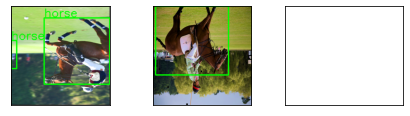

In [43]:
dataiter = iter(train_loader)
images, labels = dataiter.next()


# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    image = draw_boxes(labels[idx]["boxes"], labels[idx]["labels"], images[idx], put_text = True)
    plt.imshow(image)

In [44]:
def calculate_metrics(target_box,predictions_box,scores, device):

    #Get most confident boxes first and least confident last
    predictions_box = predictions_box[scores.argsort().flip(-1)]
    iou_mat = box_iou(target_box,predictions_box)
    #return a one by one matrix that is form (target_box, prediction_box) or (1, 1)
    target_boxes_count, prediction_boxes_count = iou_mat.shape
    
    mAP_Matrix = torch.zeros_like(iou_mat)
    # if not matrix coordinates that relate to nothing.
    if not iou_mat[:,0].eq(0.).all():
      index_of_biggest_iou = iou_mat[:,0].argsort()[-1]
      mAP_Matrix[index_of_biggest_iou,0] = 1

    for pr_idx in range(1,prediction_boxes_count):
        not_assigned = torch.logical_not(mAP_Matrix[:,:pr_idx].sum(1)).long()
        targets = not_assigned * iou_mat[:,pr_idx]

        if targets.eq(0).all():
            continue

        pivot = targets.argsort()[-1]
        mAP_Matrix[pivot,pr_idx] = 1

    # mAP calculation
    tp = mAP_Matrix.sum()
    fp = mAP_Matrix.sum(0).eq(0).sum()
    fn = mAP_Matrix.sum(1).eq(0).sum()

    mAP = tp / (tp+fp)

    return mAP

def run_metrics_for_batch(output, targets, mAP, missed_images, device):
  for pos_in_batch, image_pred in enumerate(output):
    assert (len(image_pred["boxes"]) == len(image_pred["labels"]) == len(image_pred["scores"]))
    if len(image_pred["boxes"]) != 0:
      mAP += calculate_metrics(targets[pos_in_batch]["boxes"], output[pos_in_batch]["boxes"], output[pos_in_batch]["scores"], device)
    else:
      missed_images += 1
  
  return mAP, missed_images

In [60]:
def train(net, epochs, train_loader, valid_loader, lr, weight_decay, print_times_per_epoch,
          lo_valid_dataset = len(valid_dataset), lo_train_dataset = len(train_dataset), saving_directory = None,
          unique_char_for_saving = None):

    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    print_every = len(train_dataset) / train_batch_size // print_times_per_epoch
    print("Print Every: {}".format(print_every))

    #Check which parameters can calculate gradients. 
    params = [p for p in net.parameters() if p.requires_grad]

    base_optimizer = Ranger
    optimizer = sam.SAM(net.parameters(), base_optimizer, lr = lr, weight_decay = weight_decay)
#     optimizer = optim.Adam(params, lr = lr, weight_decay = weight_decay)
    
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)

    #Might be some problems with the Data Parallel code
#     if torch.cuda.device_count() > 1:
#         print("Let's use", torch.cuda.device_count(), "GPUs!")
#         net = Some Distrubuted Parallel Function
    net.to(device)
    
    print("Device: {}".format(device))
    print("Optimizer: {}".format(optimizer))
    
    start_time = time.time()
    
    for epoch in range(epochs):
        epoch_time = time.time()
        net.train()
        
        train_loss = train_mAP = steps = train_missed_images = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):
            
            
            net.train()
            steps += 1

            images = [image.to(device) for image in images]
            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

            optimizer.zero_grad()
            
            loss_dict = net(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            net.eval()
            try:
                train_mAP, train_missed_images = run_metrics_for_batch(net(images), targets, train_mAP, train_missed_images, device)
            except:
                print(images[0].size(), targets)
                print("Caught an exception in an image could not predict metric for it")
            net.train()

            losses.backward()
#             optimizer.step()

            optimizer.first_step(zero_grad = True)

            loss_dict = net(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            losses.backward()
            optimizer.second_step(zero_grad = True)

            train_loss +=  losses.item()
            scheduler.step()

            if (steps % print_every) == 0:  
                with torch.no_grad():
                
                    valid_mAP = valid_loss = valid_missed_images = 0

                    for images, targets in valid_loader:
                        net.eval()
                        if device == torch.device("cuda"):
                            images = [image.to(device) for image in images]
                            targets = [{key: value.to(device) for key, value in t.items()} for t in targets]
                        
                        try:
                            output = net(images)
                            valid_mAP, valid_missed_images = run_metrics_for_batch(output, targets, valid_mAP, valid_missed_images, device)
                        except:
                            print(targets, images[0].size())
                            print("Caught exception with running metrics for one valid image (skipped)")

                        net.train()
                        valid_loss_dict = net(images, targets)
                        valid_losses = sum(loss for loss in valid_loss_dict.values())
                        valid_loss += valid_losses.item()

                    for param_group in optimizer.param_groups:
                        learning_rate_extract = param_group["lr"]
                    print("Epoch {}/{} | Batch Number: {} | LR: {:0.5f} | Train_loss: {:0.2f} | Valid_loss: {:0.2f} | Valid mAP: {:0.2f}% | Valid Missed Images {} / {}".format(
                        epoch + 1, epochs, steps, learning_rate_extract, train_loss, valid_loss,  
                        (valid_mAP / float(lo_valid_dataset)) * 100., valid_missed_images, lo_valid_dataset))

                assert (steps % print_every) == 0
                train_loss = 0
                
        print("\n Epoch {} | Epoch Time {:0.2f} | Final Train mAP: {:0.2f}% | Final Train Missed Images {} / {} \n".format(
            epoch + 1, (time.time() - epoch_time),(train_mAP / float(lo_train_dataset)) * 100., train_missed_images, lo_train_dataset
        ))
        if saving_directory:
            if os.path.isdir(saving_directory):
                print("Saving Model path to directory {} ... ".format(saving_directory))
                saving_path = os.path.join(saving_directory, "Epoch" + str(epoch + 1) + str(unique_char_for_saving) + ".pth")
                saving_content = {"model_state_dict": net.state_dict(), 
                                  "optimizer_state_dict": optimizer.state_dict(), 
                                  "epoch": epoch + 1, 
                                  "model_type": "FasterRCNNResnet50FPN"}
                torch.save(saving_content, saving_path)
                print("Succesfully saved model data to file path. \n")
            else:
                print("Directory Provided does not exist, hence will skip saving the model")
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))
    
        # Example File path: /saved_models/epoch10small.pth 
        

    return net

## Mish helper functions

In [61]:
# ReLU to Mish conversion for models 
#Option to switch any activation function for another.

class Mish(nn.Module):
    def __init__(self):
        super().__init__()
        print("Mish activation loaded...")

    def forward(self, x): 
        
        x = x *( torch.tanh(F.softplus(x)))

        return x
    
def convert_it(model, new, replaced_act):
    for child_name, child in model.named_children():
        if isinstance(child, replaced_act):
            setattr(model, child_name, new)
        else:
            convert_it(child, new, replaced_act)

## Faster R CNN with mobile net backbone

In [62]:
mob_net = torchvision.models.detection.faster_rcnn.fasterrcnn_resnet50_fpn(pretrained = True)
# mob_net = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
mob_net.roi_heads.box_predictor.cls_score.out_features = len(get_class_info())
mob_net.roi_heads.box_predictor.bbox_pred.out_features = len(get_class_info()) * 4
convert_it(mob_net, Mish(), nn.ReLU6)

Mish activation loaded...


## Changing LR to 0.0005

In [63]:
mob_net_trained = train(mob_net, 3, train_loader, valid_loader, 0.0005, weight_decay = 1e-5, print_times_per_epoch = 2,
                        saving_directory = "Faster_rcnn_Saved_Models", unique_char_for_saving = "FastRCNNResNetV1")


Print Every: 12.0
Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.0005
    k: 6
    lr: 0.0005
    rho: 0.05
    step_counter: 0
    weight_decay: 1e-05
)
Epoch 1/3 | Batch Number: 12 | LR: 0.00047 | Train_loss: 12.92 | Valid_loss: 1.37 | Valid mAP: 86.67% | Valid Missed Images 0 / 10
Epoch 1/3 | Batch Number: 24 | LR: 0.00038 | Train_loss: 5.23 | Valid_loss: 1.09 | Valid mAP: 45.83% | Valid Missed Images 0 / 10

 Epoch 1 | Epoch Time 52.28 | Final Train mAP: 11.18% | Final Train Missed Images 0 / 50 

Saving Model path to directory Faster_rcnn_Saved_Models ... 
Succesfully saved model data to file path. 

Epoch 2/3 | Batch Number: 12 | LR: 0.00026 | Train_loss: 3.69 | Valid_loss: 1.15 | Valid mAP: 50.83% | Valid Missed Images 0 / 10
Epoch 2/3 | Batch Number: 24 | LR: 0.00013 | Train_loss: 3

## Loading Model function. 
* Only will run if you have .pth file that configures nicely with Faster RCNN Resnet50FPN
* If model crashes while training, then might have to load in optimizer.

#### Example Code of Succesful save: 
`
checkpoint_file = "Faster_rcnn_Saved_Models/Epoch3FastRCNNResNetV1.pth"
new_mob_net = load_model_fast_rcnn(checkpoint_file) `

In [65]:
def load_model_fast_rcnn(checkpoint_file, mished = True):
    
    #Get model configuration
    model = torchvision.models.detection.faster_rcnn.fasterrcnn_resnet50_fpn(pretrained = False)
    model.roi_heads.box_predictor.cls_score.out_features = len(get_class_info())
    model.roi_heads.box_predictor.bbox_pred.out_features = len(get_class_info()) * 4
    
    if mished:
        convert_it(mob_net, Mish(), nn.ReLU6)
    
    #Load in state dicts 
    if os.path.isfile(checkpoint_file):
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint["model_state_dict"])   
    else:
        raise ValueError("Checkpoint File does not exist")
    
    return model
    

# TASK 2: Effecient Det Model Code

In [68]:
def detection_collate(batch):
    imgs = [s['image'] for s in batch]
    annots = [s['bboxes'] for s in batch]
    labels = [s['category_id'] for s in batch]

    max_num_annots = max(len(annot) for annot in annots)
    annot_padded = np.ones((len(annots), max_num_annots, 5))*-1

    if max_num_annots > 0:
        for idx, (annot, lab) in enumerate(zip(annots, labels)):
            if len(annot) > 0:
                annot_padded[idx, :len(annot), :4] = annot
                annot_padded[idx, :len(annot), 4] = lab
    return (torch.stack(imgs, 0), torch.FloatTensor(annot_padded))

eff_train_batch = 1
eff_test_batch = 1

eff_train_dataset = VideoFrameDataset("train", os.path.join("Data/VID", "train"), os.path.join("Annotations/VID", "train"), get_transforms(mode = "effdet_train"), 
                                  seg_len = 20, det_text_file_paths = None, effdet_data = True, data_size = 500)
eff_valid_dataset = VideoFrameDataset("validation", os.path.join("Data/VID", "val"), os.path.join("Annotations/VID", "val"), get_transforms(mode = "effdet_test"),
                                  make_valid_smaller_percent = 0.0125, effdet_data = True, data_size = 100)

eff_train_loader = torch.utils.data.DataLoader(eff_train_dataset, batch_size = eff_train_batch, shuffle = True, collate_fn= detection_collate)
eff_valid_loader = torch.utils.data.DataLoader(eff_valid_dataset, batch_size = eff_test_batch, shuffle = True, collate_fn = detection_collate)

print(" \n ... Seperate from Data Loader \n")
print("Length of train_dataset {}".format(len(eff_train_dataset)))
print("Length of valid_dataset {}".format(len(eff_valid_dataset)))

There are 1122397 train images in total
Amount of image files in Dataset 54647
Amount of annotation files in Dataset 54647


Loading with Effecient Det Structure ... 

Amount of image files in Dataset 2201
Amount of annotation files in Dataset 2201


Loading with Effecient Det Structure ... 

 
 ... Seperate from Data Loader 

Length of train_dataset 500
Length of valid_dataset 100


In [71]:
MODEL_MAP = {
    'efficientdet-d0': 'efficientnet-b0',
    'efficientdet-d1': 'efficientnet-b1',
    'efficientdet-d2': 'efficientnet-b2',
    'efficientdet-d3': 'efficientnet-b3',
    'efficientdet-d4': 'efficientnet-b4',
    'efficientdet-d5': 'efficientnet-b5',
    'efficientdet-d6': 'efficientnet-b6',
    'efficientdet-d7': 'efficientnet-b6',
}
class EfficientDet(nn.Module):
    def __init__(self,
                 num_classes,
                 network='efficientdet-d0',
                 D_bifpn=3,
                 W_bifpn=88,
                 D_class=3,
                 is_training=True,
                 threshold=0.001, #can change this value 0.01
                 iou_threshold=1): # can change this value 0.5
        super(EfficientDet, self).__init__()
        
        self.backbone = EfficientNet.from_pretrained(MODEL_MAP[network])
        self.is_training = is_training
        self.neck = BIFPN(in_channels=self.backbone.get_list_features()[-5:],
                          out_channels=W_bifpn,
                          stack=D_bifpn,
                          num_outs=5)
        self.bbox_head = RetinaHead(num_classes=num_classes,
                                    in_channels=W_bifpn)

        self.anchors = Anchors()
        self.regressBoxes = BBoxTransform()
        self.clipBoxes = ClipBoxes()
        self.threshold = threshold
        self.iou_threshold = iou_threshold
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        self.freeze_bn()
        self.criterion = FocalLoss()

    def forward(self, inputs):
        if self.is_training:
            inputs, annotations = inputs
        else:
            inputs = inputs
        x = self.extract_feat(inputs)
        outs = self.bbox_head(x)
        classification = torch.cat([out for out in outs[0]], dim=1)
        regression = torch.cat([out for out in outs[1]], dim=1)
        anchors = self.anchors(inputs)
        if self.is_training:
            return self.criterion(classification, regression, anchors, annotations)
        else:
            transformed_anchors = self.regressBoxes(anchors, regression)
            transformed_anchors = self.clipBoxes(transformed_anchors, inputs)
            scores = torch.max(classification, dim=2, keepdim=True)[0]
            scores_over_thresh = (scores > self.threshold)[0, :, 0]

            if scores_over_thresh.sum() == 0:
                # print('No boxes to NMS')
                # no boxes to NMS, just return
                return [torch.zeros(0), torch.zeros(0), torch.zeros(0, 4)]
            classification = classification[:, scores_over_thresh, :]
            transformed_anchors = transformed_anchors[:, scores_over_thresh, :]
            scores = scores[:, scores_over_thresh, :]
            anchors_nms_idx = nms(
                transformed_anchors[0, :, :], scores[0, :, 0], iou_threshold=self.iou_threshold)
            nms_scores, nms_class = classification[0, anchors_nms_idx, :].max(
                dim=1)
            return [nms_scores, nms_class, transformed_anchors[0, anchors_nms_idx, :]]

    def freeze_bn(self):
        '''Freeze BatchNorm layers.'''
        for layer in self.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.eval()

    def extract_feat(self, img):
        """
            Directly extract features from the backbone+neck
        """
        x = self.backbone(img)
        x = self.neck(x[-5:])
        return x

model= EfficientDet(num_classes=len(get_class_info()),is_training=True)
model.train()

model.freeze_bn()

model = model.cuda()
print('Run with DataParallel ....')

## Make sure that you add this line, even though you are not using more than one 
# GPU DataParallel adds "module" to the start of the model structure 
# allowing for the syntax to be correct when calling "model.module.freeze_bn()" for example
model = torch.nn.DataParallel(model).cuda()

# I am doing this here an example, you do not have to call the lines below here
model.module.is_training = True
model.module.freeze_bn()

convert_it(model, Mish(), nn.ReLU)

Loaded pretrained weights for efficientnet-b0
Run with DataParallel ....
Mish activation loaded...


In [10]:
def run_metrics_for_effdet_batch(scores, classification, transformed_anchors, targets, mAP, mAR, missed_images, device):
    assert (len(scores) == len(classification) == len(transformed_anchors))
    if len(transformed_anchors) != 0:
      print(targets[0][:, :4], "\n", transformed_anchors, scores)
      curr_mAP, curr_mAR = calculate_metrics(targets[0][:, :4], transformed_anchors, scores, device)
      mAP, mAR = mAP + curr_mAP , mAR + curr_mAR
    else:
      missed_images += 1 
    
# def run_metrics_for_batch(scores, classification, transformed_anchors, targets, mAP, mAR, missed_images, device):
#   for pos_in_batch, image_pred in enumerate(output):
#     assert (len(scores) == len(classification) == len(transformed_anchors))
#     if len(image_pred["boxes"]) != 0:
#       mAP += calculate_metrics(targets[pos_in_batch]["boxes"], output[pos_in_batch]["boxes"], output[pos_in_batch]["scores"], device)
#     else:
#       missed_images += 1
  
#   return mAP, missed_images
      
    return mAP, mAR, missed_images
def detection_collate(batch):
    imgs = [s['image'] for s in batch]
    annots = [s['bboxes'] for s in batch]
    labels = [s['category_id'] for s in batch]

    max_num_annots = max(len(annot) for annot in annots)
    annot_padded = np.ones((len(annots), max_num_annots, 5))*-1

    if max_num_annots > 0:
        for idx, (annot, lab) in enumerate(zip(annots, labels)):
            if len(annot) > 0:
                annot_padded[idx, :len(annot), :4] = annot
                annot_padded[idx, :len(annot), 4] = lab
    return (torch.stack(imgs, 0), torch.FloatTensor(annot_padded))

train_batch_size = 8
valid_batch_size = 1

eff_train_dataset = VideoFrameDataset("train", os.path.join("Data/VID", "train"), os.path.join("Annotations/VID", "train"), get_transforms(mode = "effdet_train"), 
                                  seg_len = 20, effdet_data = True)
eff_train_loader = torch.utils.data.DataLoader(eff_train_dataset, batch_size = train_batch_size, shuffle = True, collate_fn= detection_collate)


eff_valid_dataset = VideoFrameDataset("validation", os.path.join("Data/VID", "val"), os.path.join("Annotations/VID", "val"), get_transforms(mode = "effdet_test"),
                                  make_valid_smaller_percent = 0.01, effdet_data = True)
eff_valid_loader = torch.utils.data.DataLoader(eff_valid_dataset, batch_size = valid_batch_size, shuffle = True, collate_fn = detection_collate)


There are 1122397 train images in total
Amount of image files in Dataset 54647
Amount of annotation files in Dataset 54647


Loading with Effecient Det Structure ... 

Amount of image files in Dataset 88
Amount of annotation files in Dataset 88


Loading with Effecient Det Structure ... 



In [28]:
def train_effdet(net, epochs, train_loader, test_loader, lr, weight_decay, 
          print_times_per_epoch, lo_test_dataset = len(eff_valid_dataset), lo_train_dataset = len(eff_train_dataset)):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Device: {}".format(device))
    print("Note: Train Accuracies are only run through one train image per batch")
    
    print_every = len(train_dataset) / train_batch_size // print_times_per_epoch

    if device == torch.device("cpu"):
      warnings.warn("Code does not support running on CPU but only GPU")

    optimizer = optim.AdamW(net.parameters(), lr=lr, weight_decay = weight_decay)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = len(train_loader) * epochs)

    start_time = time.time()
    net.module.freeze_bn()
    optimizer.zero_grad()
    
    for epoch in range(epochs):

        net.train()
        net.module.is_training = True
        
        train_loss = steps = train_mAP = train_mAR = missed_train_images = 0
        
        for batch_idx, (images, targets) in enumerate(train_loader):

            net.train()
            net.module.is_training = True

            steps += 1
            
            images = images.cuda().float()
            targets = targets.cuda()

            classification_loss, regression_loss = model([images, targets])
            classification_loss = classification_loss.mean()
            regression_loss = regression_loss.mean()
            loss = classification_loss + regression_loss
            if bool(loss == 0):
              print('loss equal zero(0)')
              continue
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()

            net.eval()
            net.module.is_training = False
            scores, classification, transformed_anchors = net(images[0].unsqueeze(0))
#             train_mAP, train_mAR, missed_train_images = run_metrics_for_effdet_batch(scores, classification, transformed_anchors, targets, train_mAP, 
#                                                                                      train_mAR, missed_train_images, device)
            net.train()
            net.module.is_training = True

            train_loss += loss.item()

            if (steps % print_every) == 0:

              with torch.no_grad():
                test_mAP = test_mAR = missed_test_images = test_loss = 0

                for images, targets in test_loader:

                  if images.size(0) != 1:
                    warning.warn("Only can validate fully with batch size of 1, \
                    bigger batch sizes risk Errors or Incomplete Validation")
                  
                  net.eval()
                  net.module.is_training = False

                  if device == torch.device("cuda"):
                    images = images.cuda().float()
                    targets = targets.cuda()

                  scores, classification, transformed_anchors = net(images)
                  test_mAP, test_mAR, missed_test_images = run_metrics_for_effdet_batch(scores, classification, transformed_anchors, targets, 
                                                                                 test_mAP, test_mAR, missed_test_images, device)

                  net.train()
                  net.module.is_training = True

                  classification_loss, regression_loss = model([images, targets])
                  classification_loss = classification_loss.mean()
                  regression_loss = regression_loss.mean()
                  loss = classification_loss + regression_loss

                  test_loss += loss.item()

                for param_group in optimizer.param_groups:
                  learning_rate_extract = param_group["lr"]
                print("Epoch {}/{} | Batch Number: {} | LR: {:0.5f} | Train_loss: {:0.2f} | Test_loss: {:0.2f} | Test mAP: {:0.2f}% | Test mAR: {:0.2f}% | Missed Valid Images: {}".format(
                    epoch + 1, epochs, steps, learning_rate_extract, train_loss, test_loss,  
                    (test_mAP / float(lo_test_dataset)) * 100., (test_mAR / float(lo_test_dataset)) * 100.,missed_test_images))

              assert (steps % print_every) == 0
              train_loss = 0
              # scheduler.step(test_loss / float(lo_test_dataset))
             
        print("\n Epoch {} Final Train mAP: {:0.2f}% | Epoch {} Final Train mAR: {:0.2f}% | Epoch {} Final Missed Train Images: {} out of {} images \n".format(
            epoch + 1, (train_mAP / float(lo_train_dataset)) * 100., 
            epoch + 1, (train_mAR / float(lo_train_dataset)) * 100., 
            epoch + 1, missed_train_images, lo_train_dataset
        ))
    
    print("Time for Total Training {:0.2f}".format(time.time() - start_time))

In [29]:
train_effdet(model, 3, eff_train_loader, eff_valid_loader, 0.001, 1e-4, print_times_per_epoch = 400)

Device: cuda
Note: Train Accuracies are only run through one train image per batch
tensor([[143.,  96., 292., 235.]], device='cuda:0') 
 tensor([[  0.0000,   0.0000, 512.0000, 512.0000],
        [  0.0000,   0.0000, 512.0000, 512.0000],
        [  0.0000,   0.0000, 512.0000, 512.0000],
        ...,
        [161.3834,  33.3957, 279.5280,  35.1457],
        [  0.0000,  61.7551, 150.5256,  63.4067],
        [  0.0000, 102.2922, 512.0000, 103.9337]], device='cuda:0') tensor([1.0000, 1.0000, 1.0000,  ..., 0.0010, 0.0010, 0.0010], device='cuda:0')


TypeError: iteration over a 0-d tensor

# Write inference code for this pipeline

### Using Recurrent Neural Networks with Faster R CNNs

https://arxiv.org/pdf/2010.15740.pdf

####  Get all images file paths in a folder and all xml file paths in a folder. Then put in tuple [(image file path1, xml file path1), (image2, xml 2)]

Pair the image file paths and xml file paths into a particular scene. 
So all_scenes dict(): {folder name of one scene: list[(imf_path1, xml1), (img_path2, xml2), (img_path3, xml3)], foler name of second scene}

key_path: [scene 1, scene 2, scene 3, scene 4, scene 5]

class will get certain_scene = key_path[index] and then all_scenes[certain_scene] -> get access to list of images and labels and then load into image file path. 

create a tensor called single_scene

For one indexed scene
for tuple in list we get a tupe like this (img file path, annot file path)
open image file path of (tup[0])
open xml file and parse to get bounding boxes and other info (tup[1])

use torch.stack()

Now we have image tensor and target tensor. We can append to the single_scene.

return single_scene which is [(image 1 tensor, target tensor of 1), (image 2 tensor, target tensor of 2)] also known as all the images and targets of one scene

return this data to dataloader.



In [ ]:
def get_per_scene_dict(img_root_path, annotations_root_path):
  scene_names = glob.glob("{}/*".format(img_root_path))
  all_scenes = dict()
  for scene in scene_names:
  
    image_file_paths = glob.glob("{}{}/*.JPEG".format(img_root_path, scene.split("/")[-1]))
    xml_file_paths = glob.glob("{}{}/*.xml".format(annotations_root_path, scene.split("/")[-1]))
    image_file_paths, xml_file_paths = sorted(image_file_paths), sorted(xml_file_paths)

    assert len(image_file_paths) == len(xml_file_paths)

    scene_list = [(image_file_path, xml_file_paths[ii]) for ii, image_file_path in enumerate(image_file_paths)]
    all_scenes[scene] = scene_list
  
  return all_scenes

class VideoFrameDataset():
    
    def __init__(self, all_scenes_dict, transforms, seg_len = 5):

      self.all_scenes_dict = all_scenes_dict
      self.seg_len = seg_len
      self.transforms = transforms

    def _getitem_(self, idx):
      
      current_scene = list(self.all_scenes_dict.keys())[idx]
      list_of_fp_per_scene = self.all_scenes_dict[current_scene]

      #Random Sampling. 
      if seg_len % 5 != 0:
        raise ValueError("Not allowed value for seg_len must be divisible by 5")
      if seg_len >= len(list_of_fp_per_scene):
        raise ValueError("Segments are bigger than the amount of frames available for a scene")
      
      list_of_fp_per_scene = list_of_fp_per_scene[:-(len(list_of_fp_per_scene) % seg_len)]
      reduced_fp_per_scene, start_index = list(), 0
      for window in range(int(len(list_of_fp_per_scene) / self.seg_len))
        end_index = start_index + self.seg_len
        reduced_fp_per_scene.append(random.sample(list_of_fp_per_scene[start_index: end_index], 1)[0])
        start_index = end_index
      
      scene_images, scene_bboxes = [], []
      for data in reduced_fp_per_scene:
        img_path, xml_path = data

        img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        xml_doc = ElementTree.parse(xml_path)

        bounding_boxes = xml_doc.findall("object/bndbox")

        bbox = []
        for node in bounding_boxes:
          xmax = node.find("xmax").text
          xmin = node.find("xmin").text
          ymax = node.find("ymax").text
          ymin = node.find("ymin").text

          bbox.append([int(xmin), int(ymin), int(xmax), int(ymax)])
        
        bbox = torch.as_tensor(bbox, dtype = torch.float32)
        
        if self.transforms: 
          sample = {
              'image': img,
              'bboxes': bbox,
              'labels': labels
              }

        sample = self.transforms(**sample)
        augmented_img = sample['image']
        augmented_bbox = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)

        scene_bboxes.append(augmented_bbox)
        scene_images.append(augmented_img)
      
      scene_images, scene_bboxes = torch.stack(scene_images), torch.stack(scene_bboxes)

      scene_target = dict() 
      scene_target["boxes"] = scene_bboxes

      scene_target["image_id"] = ###############################################
      scene_target["labels"] = #################################################

      return scene_images, scene_target
      

     


   

In [ ]:
def test(net, test_loader, ####):

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  with torch.no_grad():
    test_mAP = test_loss = test_missed_images = 0
    for images, targets in test_loader:

        if device == torch.device("cuda"):
          images = [image.to(device) for image in images]
          targets = [{key: value.to(device) for key, value in t.items()} for t in targets]

        net.eval()
        output = net(images)
        test_mAP, test_missed_images = run_metrics_for_batch(output, targets, test_mAP, test_missed_images, device)

        net.train()
        test_loss_dict = net(images, targets)
        test_losses = sum(loss for loss in test_loss_dict.values())
        test_loss += test_losses

    print("Test mAP {:0.2f}% | Test Loss {:0.2f} | Test Missed Images {} / {}".format(test_mAP, test_loss, test_missed_images, #####))



### Links that I used to get notebook running with correct 3rd party packages

* https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/
* https://www.digitalocean.com/community/tutorials/how-to-set-up-jupyter-notebook-with-python-3-on-ubuntu-18-04
* Make sure after running packages update on conda environment to shut down and reopen notebook for update.
* Just git clone in the notebook

In [76]:
class VideoFrameDataset():
    
    def __init__(self, mode, vid_data_root_dir, vid_annotations_root_dir, transforms, amount_per_folder = None, 
               make_valid_smaller_percent = None, effdet_data = None, rcnn_big = None, det_text_file_paths = None):
        
    # If valid smaller is true cut the length of valid list to certain length with if statement. 
        if (mode == "train"):
            if (amount_per_folder):
                #Subset images from every scene there are 3862 data folders.
                print("There are 3862 train data folders in total")
                globbed_image_file_paths = sorted(glob.glob("{}/*/*".format(vid_data_root_dir)))
                globbed_annotations_file_paths = sorted(glob.glob("{}/*/*".format(vid_annotations_root_dir)))
                
                self.image_file_paths, self.annotations_file_paths = list(), list()
                
                for folder in list(zip(globbed_image_file_paths, globbed_annotations_file_paths)):
                    scene_images = sorted(glob.glob("{}/*.JPEG".format(folder[0])))
                    scene_annotations = sorted(glob.glob("{}/*.xml".format(folder[1])))
                    
                    image_annot = list(zip(scene_images, scene_annotations))
                    #Use span evenly distributed 
                    
                    image_annot = random.sample(image_annot, amount_per_folder)
                    
                    scene_images, scene_annotations = zip(*image_annot) 
                    
                    self.annotations_file_paths.extend(scene_annotations)
                    self.image_file_paths.extend(scene_images)
                    
            else:
                self.image_file_paths = sorted(glob.glob("{}/*/*/*.JPEG".format(vid_data_root_dir))) 
                self.annotations_file_paths = sorted(glob.glob("{}/*/*/*.xml".format(vid_annotations_root_dir)))
            
        elif (mode == "validation"):
            if make_valid_smaller_percent:
                #Subset a percent of the valid data
                valid_image_list = sorted(glob.glob("{}/*/*.JPEG".format(vid_data_root_dir)))
                valid_annotations_list = sorted(glob.glob("{}/*/*.xml".format(vid_annotations_root_dir)))

                subset = int(len(valid_image_list) * make_valid_smaller_percent)

                #Shuffle both lists at once with same order
                mapIndexPosition = list(zip(valid_image_list, valid_annotations_list))
                random.shuffle(mapIndexPosition)
                valid_image_list, valid_annotations_list = zip(*mapIndexPosition)
                valid_image_list, valid_annotations_list = list(valid_image_list), list(valid_annotations_list)

                self.image_file_paths = valid_image_list[:subset]
                self.annotations_file_paths = valid_annotations_list[:subset]
            else:
                self.image_file_paths = sorted(glob.glob("{}/*/*.JPEG".format(vid_data_root_dir))) 
                self.annotations_file_paths = sorted(glob.glob("{}/*/*.xml".format(vid_annotations_root_dir)))
        else:
            raise ValueError("Choose mode between train or validation only")

        self.labels_key = get_class_info(get_keys = True)

        assert len(self.image_file_paths) == len(self.annotations_file_paths)
        print("Amount of image files in Dataset {}".format(len(self.image_file_paths)))
        print("Amount of annotation files in Dataset {}".format(len(self.annotations_file_paths)))

        self.transforms = transforms
        self.effdet_data = effdet_data
        self.rcnn_big = rcnn_big
        
#         if det_text_file_paths:
#             det_txt = open(det_text_file_paths, "r").readlines()
#             for line in det_txt:
#                 if len(line) == 56:
#                     self.image_file_paths.append((line.split(" ")[0] + ".JPEG"))
#                     self.annotations_file_paths.append((line.split(" ")[0] + ".xml"))
        
        
        if self.effdet_data:
            print("\n")
            print("Loading with Effecient Det Structure ... \n")
        elif self.rcnn_big:
            print("\n")
            print("Loading with bigger rcnn with ROI Structure ... \n")
        else:
            print("\n")
            print("Loading with mobilenet Faster R CNN Structure ... \n")
    
    def __getitem__(self, idx):

        img_path, xml_path = self.image_file_paths[idx], self.annotations_file_paths[idx]

        img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
        # img = cv2.cvtColor(cv2.imread(img_path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

        xml_doc = ElementTree.parse(xml_path)

        bounding_boxes_nodes = xml_doc.findall("object/bndbox")
        labels_nodes = xml_doc.findall("object/name")

        bbox, labels = [], []

        for node in bounding_boxes_nodes:
            xmax = node.find("xmax").text
            xmin = node.find("xmin").text
            ymax = node.find("ymax").text
            ymin = node.find("ymin").text
            bbox.append([int(xmin), int(ymin), int(xmax), int(ymax)])  
        bbox = torch.as_tensor(bbox, dtype = torch.float32)

        for node in labels_nodes:
            if self.effdet_data or self.rcnn_big:
                label = self.labels_key.index(node.text)
            else:
                label = self.labels_key.index(node.text) + 1
            labels.append(label)
        labels = torch.as_tensor(labels, dtype = torch.int64)

        # labels = tf.cast(labels, dtype = tf.int64)

        image_id = torch.tensor([idx])
        
        try:
            if self.transforms:  
                sample = {
                    'image': img,
                    'bboxes': bbox,
                    'labels': labels
                      }

                sample = self.transforms(**sample)
                img = sample['image']
                try:
                    bbox = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                except:
                    bbox = torch.zeros((0, 4), dtype=torch.float32)
        except:
            print("Caught error. Now trying to instill transforms using Pytorch transforms")
            
            img = Image.open(img_path).convert("RGB")
            img = transforms.ToTensor()(img) 
                
          # img = tf.cast(sample['image'], dtype = tf.float32) / 255.0
          # bbox = tf.convert_to_tensor(torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0), dtype = tf.float32)

        if self.effdet_data:
            return {"image": img, "bboxes": bbox, "category_id": labels}
        
        target = dict()
        target["boxes"] = bbox
        target["labels"] = labels
        target["image_id"] = image_id

        return img, target  
    
    def __len__(self):

        return len(self.image_file_paths)

In [18]:
r_cnn_trained = train(model, 1, train_loader, valid_loader, 0.001, weight_decay = 1e-4, print_times_per_epoch = 400)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.001
    k: 6
    lr: 0.001
    rho: 0.05
    step_counter: 0
    weight_decay: 0.0001
)


/home/sarthak/DataSets/ILSVRC2015/Ranger-Deep-Learning-Optimizer/ranger/ranger.py:138: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370128159/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
/home/sarthak/anaconda3/envs/deep-learning-base/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://py

Epoch 1/1 | Batch Number: 28 | LR: 0.00100 | Train_loss: 94.32 | Valid_loss: 76.92 | Valid mAP: 1.16% | Valid Missed Images 75 / 88
Epoch 1/1 | Batch Number: 56 | LR: 0.00100 | Train_loss: 27.41 | Valid_loss: 62.92 | Valid mAP: 3.97% | Valid Missed Images 76 / 88
Epoch 1/1 | Batch Number: 84 | LR: 0.00100 | Train_loss: 25.47 | Valid_loss: 50.36 | Valid mAP: 11.10% | Valid Missed Images 57 / 88
Epoch 1/1 | Batch Number: 112 | LR: 0.00100 | Train_loss: 18.71 | Valid_loss: 40.04 | Valid mAP: 7.95% | Valid Missed Images 69 / 88
Epoch 1/1 | Batch Number: 140 | LR: 0.00100 | Train_loss: 21.55 | Valid_loss: 39.10 | Valid mAP: 0.32% | Valid Missed Images 66 / 88
Epoch 1/1 | Batch Number: 168 | LR: 0.00100 | Train_loss: 17.03 | Valid_loss: 32.78 | Valid mAP: 3.97% | Valid Missed Images 77 / 88
Epoch 1/1 | Batch Number: 196 | LR: 0.00100 | Train_loss: 18.85 | Valid_loss: 36.41 | Valid mAP: 24.06% | Valid Missed Images 32 / 88
Epoch 1/1 | Batch Number: 224 | LR: 0.00100 | Train_loss: 14.55 | Vali

KeyboardInterrupt: 

In [23]:
mob_net_trained = train(mob_net, 1, train_loader, valid_loader, 0.0001, weight_decay = 1e-5, print_times_per_epoch = 50)

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers
Device: cuda
Optimizer: SAM (
Parameter Group 0
    N_sma_threshhold: 5
    alpha: 0.5
    betas: (0.95, 0.999)
    eps: 1e-05
    initial_lr: 0.0001
    k: 6
    lr: 0.0001
    rho: 0.05
    step_counter: 0
    weight_decay: 1e-05
)


/home/sarthak/DataSets/ILSVRC2015/Ranger-Deep-Learning-Optimizer/ranger/ranger.py:138: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370128159/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
/home/sarthak/anaconda3/envs/deep-learning-base/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://py

Epoch 1/1 | Batch Number: 22447 | LR: 0.00010 | Train_loss: 112178093.03 | Valid_loss: 1046.19 | Valid mAP: 6.47% | Valid Missed Images 0 / 1761
Epoch 1/1 | Batch Number: 44894 | LR: 0.00010 | Train_loss: 3822367.73 | Valid_loss: 1813196.61 | Valid mAP: 20.79% | Valid Missed Images 0 / 1761
Epoch 1/1 | Batch Number: 67341 | LR: 0.00010 | Train_loss: 68994806.74 | Valid_loss: 666.07 | Valid mAP: 1.79% | Valid Missed Images 1709 / 1761


ValueError: Expected x_max for bbox (tensor(0.9219), tensor(0.3847), tensor(1.0063), tensor(0.5528), tensor(7)) to be in the range [0.0, 1.0], got 1.006250023841858.

In [ ]:
class Resizer(object):
    """Convert ndarrays in sample to Tensors."""
    
    def __init__(self, img_size=512):
        self.img_size = img_size

    def __call__(self, sample):
        image, annots = sample['img'], sample['annot']
        height, width, _ = image.shape
        if height > width:
            scale = self.img_size / height
            resized_height = self.img_size
            resized_width = int(width * scale)
        else:
            scale = self.img_size / width
            resized_height = int(height * scale)
            resized_width = self.img_size

        image = cv2.resize(image, (resized_width, resized_height), interpolation=cv2.INTER_LINEAR)

        new_image = np.zeros((self.img_size, self.img_size, 3))
        new_image[0:resized_height, 0:resized_width] = image

        annots[:, :4] *= scale

        return {'img': torch.from_numpy(new_image).to(torch.float32), 'annot': torch.from_numpy(annots), 'scale': scale}


class Augmenter(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample, flip_x=0.5):
        if np.random.rand() < flip_x:
            image, annots = sample['img'], sample['annot']
            image = image[:, ::-1, :]

            rows, cols, channels = image.shape

            x1 = annots[:, 0].copy()
            x2 = annots[:, 2].copy()

            x_tmp = x1.copy()

            annots[:, 0] = cols - x2
            annots[:, 2] = cols - x_tmp

            sample = {'img': image, 'annot': annots}

        return sample


class Normalizer(object):

    def __init__(self, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
        self.mean = np.array([[mean]])
        self.std = np.array([[std]])

    def __call__(self, sample):
        image, annots = sample['img'], sample['annot']

        return {'img': ((image.astype(np.float32) - self.mean) / self.std), 'annot': annots}